# Feature Extractor Model
In this notebook, we will be experimenting with different deep learning models to classify single white blood cell images into normal or leukemia blasts with this [Acute Lymphoblastic Leukemia (ALL) dataset](https://www.kaggle.com/datasets/andrewmvd/leukemia-classification).

In [ ]:
# import necessary packages and libraries
import pandas as pd
import numpy as np
import seaborn as sns
import os
import os.path
from pathlib import Path
import glob
from PIL import Image
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import keras
from sklearn.model_selection import train_test_split
from keras import regularizers
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve
from keras.optimizers import RMSprop,Adam,Optimizer,Optimizer
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization,MaxPooling2D,BatchNormalization,\
                        Permute, TimeDistributed, Bidirectional,GRU, SimpleRNN, LSTM, GlobalAveragePooling2D, SeparableConv2D
from keras import models
from keras import layers
import tensorflow as tf
from keras.applications import VGG16,VGG19,inception_v3
from keras import backend as K
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


###Blood Cell Count and Detection (BCCD) dataset
We begin our pipeline with the BCCD (Blood Cell Count and Detection) dataset, which contains annotated microscopic images of blood cells. This dataset includes four main types of white blood cells (WBCs):

- Eosinophils

- Lymphocytes

- Monocytes

- Neutrophils

The objective here is to train a multi-class classifier to accurately identify and distinguish between these WBC categories. By doing so, we establish a strong feature extractor that understands the visual characteristics of various WBC types, that can be later adapted for leukemia detection from full blood smear images, by transferring and fine-tuning the learned features.

In [ ]:
# import BCCD dataset
!unzip -q dataset2-master.zip
!ls

dataset2-master  dataset2-master.zip  __MACOSX	sample_data


In [ ]:
Train_Data_Path = Path("/content/dataset2-master/images/TRAIN")
Test_Data_Path = Path("/content/dataset2-master/images/TEST")
Validation_Data_Path = Path("/content/dataset2-master/images/TEST_SIMPLE")

In [ ]:
Train_JPG_Path = list(Train_Data_Path.glob(r"**/*.jpeg"))
Test_JPG_Path = list(Test_Data_Path.glob(r"**/*.jpeg"))
Validation_JPG_Path = list(Validation_Data_Path.glob(r"**/*.jpeg"))
Train_JPG_Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],Train_JPG_Path))

In [ ]:
print("EOSINOPHIL: ", Train_JPG_Labels.count("EOSINOPHIL"))
print("LYMPHOCYTE: ", Train_JPG_Labels.count("LYMPHOCYTE"))
print("MONOCYTE: ", Train_JPG_Labels.count("MONOCYTE"))
print("NEUTROPHIL: ", Train_JPG_Labels.count("NEUTROPHIL"))

EOSINOPHIL:  2497
LYMPHOCYTE:  2483
MONOCYTE:  2478
NEUTROPHIL:  2499


In [ ]:
Test_JPG_Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],Test_JPG_Path))

In [ ]:
print("EOSINOPHIL: ", Test_JPG_Labels.count("EOSINOPHIL"))
print("LYMPHOCYTE: ", Test_JPG_Labels.count("LYMPHOCYTE"))
print("MONOCYTE: ", Test_JPG_Labels.count("MONOCYTE"))
print("NEUTROPHIL: ", Test_JPG_Labels.count("NEUTROPHIL"))

EOSINOPHIL:  623
LYMPHOCYTE:  620
MONOCYTE:  620
NEUTROPHIL:  624


In [ ]:
Validation_JPG_Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],Validation_JPG_Path))

In [ ]:
print("EOSINOPHIL: ", Validation_JPG_Labels.count("EOSINOPHIL"))
print("LYMPHOCYTE: ", Validation_JPG_Labels.count("LYMPHOCYTE"))
print("MONOCYTE: ", Validation_JPG_Labels.count("MONOCYTE"))
print("NEUTROPHIL: ", Validation_JPG_Labels.count("NEUTROPHIL"))

EOSINOPHIL:  13
LYMPHOCYTE:  6
MONOCYTE:  4
NEUTROPHIL:  48


In [ ]:
Train_JPG_Path_Series = pd.Series(Train_JPG_Path,name="JPG").astype(str)

Train_JPG_Labels_Series = pd.Series(Train_JPG_Labels,name="CATEGORY")

Test_JPG_Path_Series = pd.Series(Test_JPG_Path,name="JPG").astype(str)

Test_JPG_Labels_Series = pd.Series(Test_JPG_Labels,name="CATEGORY")

Validation_JPG_Path_Series = pd.Series(Validation_JPG_Path,name="JPG").astype(str)

Validation_JPG_Labels_Series = pd.Series(Validation_JPG_Labels,name="CATEGORY")

In [ ]:
Main_Train_Data = pd.concat([Train_JPG_Path_Series,Train_JPG_Labels_Series],axis=1)
print(Main_Train_Data.head(-1))

                                                    JPG    CATEGORY
0     /content/dataset2-master/images/TRAIN/EOSINOPH...  EOSINOPHIL
1     /content/dataset2-master/images/TRAIN/EOSINOPH...  EOSINOPHIL
2     /content/dataset2-master/images/TRAIN/EOSINOPH...  EOSINOPHIL
3     /content/dataset2-master/images/TRAIN/EOSINOPH...  EOSINOPHIL
4     /content/dataset2-master/images/TRAIN/EOSINOPH...  EOSINOPHIL
...                                                 ...         ...
9951  /content/dataset2-master/images/TRAIN/NEUTROPH...  NEUTROPHIL
9952  /content/dataset2-master/images/TRAIN/NEUTROPH...  NEUTROPHIL
9953  /content/dataset2-master/images/TRAIN/NEUTROPH...  NEUTROPHIL
9954  /content/dataset2-master/images/TRAIN/NEUTROPH...  NEUTROPHIL
9955  /content/dataset2-master/images/TRAIN/NEUTROPH...  NEUTROPHIL

[9956 rows x 2 columns]


In [ ]:
Main_Test_Data = pd.concat([Test_JPG_Path_Series,Test_JPG_Labels_Series],axis=1)
print(Main_Test_Data.head(-1))

                                                    JPG    CATEGORY
0     /content/dataset2-master/images/TEST/EOSINOPHI...  EOSINOPHIL
1     /content/dataset2-master/images/TEST/EOSINOPHI...  EOSINOPHIL
2     /content/dataset2-master/images/TEST/EOSINOPHI...  EOSINOPHIL
3     /content/dataset2-master/images/TEST/EOSINOPHI...  EOSINOPHIL
4     /content/dataset2-master/images/TEST/EOSINOPHI...  EOSINOPHIL
...                                                 ...         ...
2481  /content/dataset2-master/images/TEST/NEUTROPHI...  NEUTROPHIL
2482  /content/dataset2-master/images/TEST/NEUTROPHI...  NEUTROPHIL
2483  /content/dataset2-master/images/TEST/NEUTROPHI...  NEUTROPHIL
2484  /content/dataset2-master/images/TEST/NEUTROPHI...  NEUTROPHIL
2485  /content/dataset2-master/images/TEST/NEUTROPHI...  NEUTROPHIL

[2486 rows x 2 columns]


In [ ]:
Main_Validation_Data = pd.concat([Validation_JPG_Path_Series,Validation_JPG_Labels_Series],axis=1)
print(Main_Validation_Data.head(-1))

                                                  JPG    CATEGORY
0   /content/dataset2-master/images/TEST_SIMPLE/EO...  EOSINOPHIL
1   /content/dataset2-master/images/TEST_SIMPLE/EO...  EOSINOPHIL
2   /content/dataset2-master/images/TEST_SIMPLE/EO...  EOSINOPHIL
3   /content/dataset2-master/images/TEST_SIMPLE/EO...  EOSINOPHIL
4   /content/dataset2-master/images/TEST_SIMPLE/EO...  EOSINOPHIL
..                                                ...         ...
65  /content/dataset2-master/images/TEST_SIMPLE/NE...  NEUTROPHIL
66  /content/dataset2-master/images/TEST_SIMPLE/NE...  NEUTROPHIL
67  /content/dataset2-master/images/TEST_SIMPLE/NE...  NEUTROPHIL
68  /content/dataset2-master/images/TEST_SIMPLE/NE...  NEUTROPHIL
69  /content/dataset2-master/images/TEST_SIMPLE/NE...  NEUTROPHIL

[70 rows x 2 columns]


In [ ]:
Main_Train_Data = Main_Train_Data.sample(frac=1).reset_index(drop=True)
print(Main_Train_Data.head(-1))

                                                    JPG    CATEGORY
0     /content/dataset2-master/images/TRAIN/EOSINOPH...  EOSINOPHIL
1     /content/dataset2-master/images/TRAIN/NEUTROPH...  NEUTROPHIL
2     /content/dataset2-master/images/TRAIN/EOSINOPH...  EOSINOPHIL
3     /content/dataset2-master/images/TRAIN/NEUTROPH...  NEUTROPHIL
4     /content/dataset2-master/images/TRAIN/MONOCYTE...    MONOCYTE
...                                                 ...         ...
9951  /content/dataset2-master/images/TRAIN/LYMPHOCY...  LYMPHOCYTE
9952  /content/dataset2-master/images/TRAIN/NEUTROPH...  NEUTROPHIL
9953  /content/dataset2-master/images/TRAIN/LYMPHOCY...  LYMPHOCYTE
9954  /content/dataset2-master/images/TRAIN/NEUTROPH...  NEUTROPHIL
9955  /content/dataset2-master/images/TRAIN/MONOCYTE...    MONOCYTE

[9956 rows x 2 columns]


In [ ]:
Main_Test_Data = Main_Test_Data.sample(frac=1).reset_index(drop=True)
print(Main_Test_Data.head(-1))

                                                    JPG    CATEGORY
0     /content/dataset2-master/images/TEST/LYMPHOCYT...  LYMPHOCYTE
1     /content/dataset2-master/images/TEST/EOSINOPHI...  EOSINOPHIL
2     /content/dataset2-master/images/TEST/EOSINOPHI...  EOSINOPHIL
3     /content/dataset2-master/images/TEST/EOSINOPHI...  EOSINOPHIL
4     /content/dataset2-master/images/TEST/EOSINOPHI...  EOSINOPHIL
...                                                 ...         ...
2481  /content/dataset2-master/images/TEST/NEUTROPHI...  NEUTROPHIL
2482  /content/dataset2-master/images/TEST/EOSINOPHI...  EOSINOPHIL
2483  /content/dataset2-master/images/TEST/EOSINOPHI...  EOSINOPHIL
2484  /content/dataset2-master/images/TEST/LYMPHOCYT...  LYMPHOCYTE
2485  /content/dataset2-master/images/TEST/MONOCYTE/...    MONOCYTE

[2486 rows x 2 columns]


In [ ]:
Main_Validation_Data = Main_Validation_Data.sample(frac=1).reset_index(drop=True)
print(Main_Validation_Data.head(-1))

                                                  JPG    CATEGORY
0   /content/dataset2-master/images/TEST_SIMPLE/NE...  NEUTROPHIL
1   /content/dataset2-master/images/TEST_SIMPLE/LY...  LYMPHOCYTE
2   /content/dataset2-master/images/TEST_SIMPLE/NE...  NEUTROPHIL
3   /content/dataset2-master/images/TEST_SIMPLE/NE...  NEUTROPHIL
4   /content/dataset2-master/images/TEST_SIMPLE/LY...  LYMPHOCYTE
..                                                ...         ...
65  /content/dataset2-master/images/TEST_SIMPLE/NE...  NEUTROPHIL
66  /content/dataset2-master/images/TEST_SIMPLE/NE...  NEUTROPHIL
67  /content/dataset2-master/images/TEST_SIMPLE/EO...  EOSINOPHIL
68  /content/dataset2-master/images/TEST_SIMPLE/NE...  NEUTROPHIL
69  /content/dataset2-master/images/TEST_SIMPLE/MO...    MONOCYTE

[70 rows x 2 columns]


In [ ]:
Train_Generator = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.1,            # less zoom
    shear_range=0.1,           # less shearing
    rotation_range=15,         # smaller rotations
    horizontal_flip=True,
    fill_mode="nearest"
)

Test_Validation_Generator = ImageDataGenerator(rescale=1./255, validation_split=0.5)

In [ ]:
exp_IMG = Main_Train_Data["JPG"][22]
Load_IMG = image.load_img(exp_IMG,target_size=(220,220))
Array_IMG = image.img_to_array(Load_IMG)
Array_IMG = Array_IMG.reshape((1,) + Array_IMG.shape)

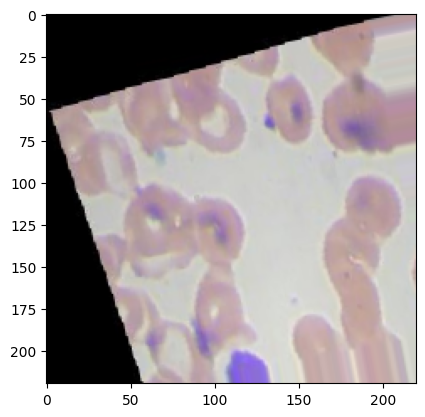

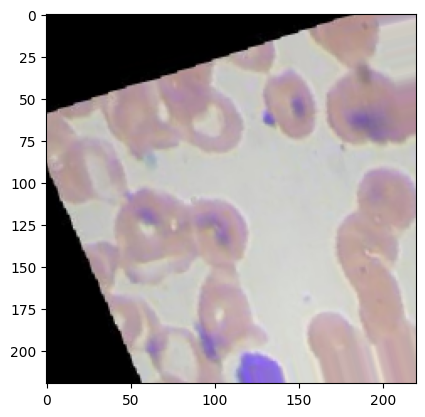

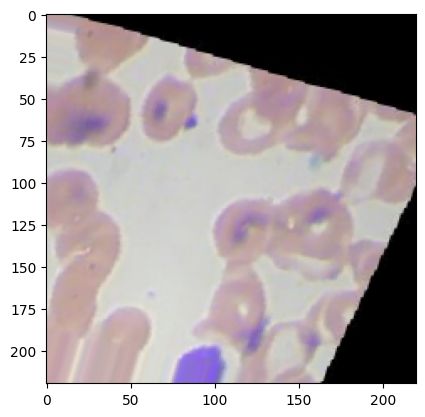

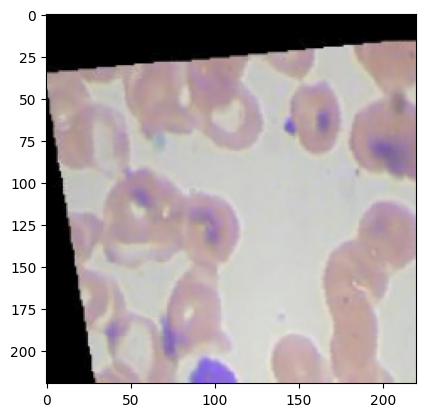

In [ ]:
import matplotlib.pyplot as plt

i = 0
for batch in Train_Generator.flow(Array_IMG,batch_size=1):
    plt.figure(i)
    IMG = plt.imshow(image.img_to_array(batch[0]))
    i += 1
    if i % 4 == 0:
        break
plt.show()

In [ ]:
Train_IMG_Set = Train_Generator.flow_from_dataframe(dataframe=Main_Train_Data,
                                                   x_col="JPG",
                                                   y_col="CATEGORY",
                                                   color_mode="rgb",
                                                   class_mode="categorical",
                                                   subset="training",
                                                   seed=42,
                                                   batch_size=32,
                                                   target_size=(220,220))

Found 9957 validated image filenames belonging to 4 classes.


In [ ]:
Test_IMG_Set = Test_Validation_Generator.flow_from_dataframe(dataframe=Main_Test_Data,
                                                            x_col="JPG",
                                                            y_col="CATEGORY",
                                                            color_mode="rgb",
                                                            class_mode="categorical",
                                                            seed=42,
                                                            batch_size=32,
                                                            target_size=(220,220))

Found 2487 validated image filenames belonging to 4 classes.


In [ ]:
Validation_IMG_Set = Test_Validation_Generator.flow_from_dataframe(dataframe=Main_Validation_Data,
                                                                  x_col="JPG",
                                                                  y_col="CATEGORY",
                                                                  color_mode="rgb",
                                                                  class_mode="categorical",
                                                                  seed=42,
                                                                  batch_Size=32,
                                                                  target_size=(220,220),
                                                                  subset="validation")

Found 35 validated image filenames belonging to 4 classes.


In [ ]:
for data_batch,label_batch in Train_IMG_Set:
    print("DATA SHAPE: ",data_batch.shape)
    print("LABEL SHAPE: ",label_batch.shape)
    break

DATA SHAPE:  (32, 220, 220, 3)
LABEL SHAPE:  (32, 4)


In [ ]:
for data_batch,label_batch in Validation_IMG_Set:
    print("DATA SHAPE: ",data_batch.shape)
    print("LABEL SHAPE: ",label_batch.shape)
    break

DATA SHAPE:  (32, 220, 220, 3)
LABEL SHAPE:  (32, 4)


In [ ]:
for data_batch,label_batch in Test_IMG_Set:
    print("DATA SHAPE: ",data_batch.shape)
    print("LABEL SHAPE: ",label_batch.shape)
    break

DATA SHAPE:  (32, 220, 220, 3)
LABEL SHAPE:  (32, 4)


##CNN Model

After experimenting with different model architectures, this CNN Model below achieved the highest accuracy and best results.

In [ ]:
# Final Model Architecture
Model = Sequential()

# Block 1
Model.add(SeparableConv2D(32, (3,3), padding='same', input_shape=(220, 220, 3)))
Model.add(BatchNormalization())
Model.add(Activation('relu'))
Model.add(MaxPooling2D(pool_size=(2, 2)))
Model.add(Dropout(0.25))

# Block 2
Model.add(SeparableConv2D(64, (3,3), padding='same'))
Model.add(BatchNormalization())
Model.add(Activation('relu'))
Model.add(MaxPooling2D(pool_size=(2, 2)))
Model.add(Dropout(0.3))

# Block 3
Model.add(SeparableConv2D(128, (3,3), padding='same'))
Model.add(BatchNormalization())
Model.add(Activation('relu'))
Model.add(MaxPooling2D(pool_size=(2, 2)))
Model.add(Dropout(0.4))

# Global Pooling and Dense Layers
Model.add(GlobalAveragePooling2D())
Model.add(Dense(256, activation='relu'))
Model.add(Dropout(0.5))
Model.add(Dense(4, activation='softmax'))

# Optimizer and Compile
optimizer = Adam(learning_rate=0.001)
Model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
Call_Back = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', restore_best_weights=True)
LR_Scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Training the model
CNN_Model = Model.fit(
    Train_IMG_Set,
    validation_data=Validation_IMG_Set,
    callbacks=[Call_Back, LR_Scheduler],
    epochs=50  # stop early when validation stops improving
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_separable_conv.py:104: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 153s 447ms/step - accuracy: 0.3295 - loss: 1.3785 - val_accuracy: 0.2286 - val_loss: 1.1558 - learning_rate: 0.0010
Epoch 2/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 127s 407ms/step - accuracy: 0.5585 - loss: 1.0028 - val_accuracy: 0.6571 - val_loss: 1.2898 - learning_rate: 0.0010
Epoch 3/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 129s 413ms/step - accuracy: 0.6873 - loss: 0.7433 - val_accuracy: 0.6000 - val_loss: 2.0393 - learning_rate: 0.0010
Epoch 4/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 140s 407ms/step - accuracy: 0.7446 - loss: 0.6354 - val_accuracy: 0.2000 - val_loss: 36.1577 - learning_rate: 0.0010
Epoch 5/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 127s 406ms/step - accuracy: 0.8123 - loss: 0.4852 - val_accuracy: 0.7143 - val_loss: 0.8299 - learning_rate: 2.0000e-04
Epoch 6/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 138s 443ms/step - accuracy: 0.8235 - loss: 0.4471 - val_accuracy: 0.2000 - val_loss: 3.1792 - learning_rate: 2.0000e-04
Epoch 7/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 135s 432ms/step

In [ ]:
test_loss, test_accuracy = Model.evaluate(Test_IMG_Set)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - accuracy: 0.8365 - loss: 0.4993
Test Accuracy: 83.51%
Test Loss: 0.5082


In [ ]:
# save this model to use later
Model.save("wbc_classifier.keras")

##EfficientNetB0

In [ ]:
base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(220, 220, 3)
)
base_model.trainable = False  # Freeze the base model for now


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)


In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)


history = model.fit(
    Train_IMG_Set,
    validation_data=Validation_IMG_Set,
    epochs=30,
    callbacks=[early_stop, lr_schedule]
)

Epoch 1/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.2525 - loss: 1.3870

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


312/312 ━━━━━━━━━━━━━━━━━━━━ 174s 483ms/step - accuracy: 0.2525 - loss: 1.3870 - val_accuracy: 0.1143 - val_loss: 1.3856 - learning_rate: 5.0000e-04
Epoch 2/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 127s 406ms/step - accuracy: 0.2478 - loss: 1.3869 - val_accuracy: 0.1143 - val_loss: 1.3860 - learning_rate: 5.0000e-04
Epoch 3/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 127s 407ms/step - accuracy: 0.2498 - loss: 1.3863 - val_accuracy: 0.6571 - val_loss: 1.3849 - learning_rate: 5.0000e-04
Epoch 4/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 127s 407ms/step - accuracy: 0.2394 - loss: 1.3863 - val_accuracy: 0.6571 - val_loss: 1.3839 - learning_rate: 5.0000e-04
Epoch 5/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 128s 411ms/step - accuracy: 0.2526 - loss: 1.3863 - val_accuracy: 0.2000 - val_loss: 1.3845 - learning_rate: 5.0000e-04
Epoch 6/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 126s 402ms/step - accuracy: 0.2477 - loss: 1.3863 - val_accuracy: 0.6571 - val_loss: 1.3820 - learning_rate: 5.0000e-04
Epoch 7/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 127s 406ms/

In [ ]:
test_loss, test_accuracy = model.evaluate(Test_IMG_Set)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


78/78 ━━━━━━━━━━━━━━━━━━━━ 21s 170ms/step - accuracy: 0.2446 - loss: 1.3863
Test Accuracy: 25.09%
Test Loss: 1.3863


##InceptionV3

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
# Augmentation + Preprocessing for InceptionV3
Train_Valid_Generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

Train_IMG_Set = Train_Valid_Generator.flow_from_dataframe(
    dataframe=Main_Train_Data,
    x_col='JPG',
    y_col='CATEGORY',
    subset='training',
    target_size=(220, 220),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

Validation_IMG_Set = Train_Valid_Generator.flow_from_dataframe(
    dataframe=Main_Train_Data,
    x_col='JPG',
    y_col='CATEGORY',
    subset='validation',
    target_size=(220, 220),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

# Clean test data (no augmentation, same preprocessing)
Test_Generator = ImageDataGenerator(preprocessing_function=preprocess_input)

Test_IMG_Set = Test_Generator.flow_from_dataframe(
    dataframe=Main_Test_Data,
    x_col='JPG',
    y_col='CATEGORY',
    target_size=(220, 220),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 7966 validated image filenames belonging to 4 classes.
Found 1991 validated image filenames belonging to 4 classes.
Found 2487 validated image filenames belonging to 4 classes.


In [ ]:
# Load pretrained base model
base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(220, 220, 3))
base_model.trainable = False  # Freeze base model for now

# Add custom head
inputs = Input(shape=(220, 220, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(4, activation='softmax')(x)  # Adjust if you have more/less than 4 classes

model = Model(inputs, outputs)


In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
]

history = model.fit(
    Train_IMG_Set,
    validation_data=Validation_IMG_Set,
    epochs=30,
    callbacks=callbacks
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
249/249 ━━━━━━━━━━━━━━━━━━━━ 172s 616ms/step - accuracy: 0.3421 - loss: 1.5575 - val_accuracy: 0.4937 - val_loss: 1.2050 - learning_rate: 0.0010
Epoch 2/30
249/249 ━━━━━━━━━━━━━━━━━━━━ 130s 520ms/step - accuracy: 0.4419 - loss: 1.2192 - val_accuracy: 0.5455 - val_loss: 1.1104 - learning_rate: 0.0010
Epoch 3/30
249/249 ━━━━━━━━━━━━━━━━━━━━ 130s 523ms/step - accuracy: 0.4812 - loss: 1.1538 - val_accuracy: 0.5635 - val_loss: 1.0570 - learning_rate: 0.0010
Epoch 4/30
249/249 ━━━━━━━━━━━━━━━━━━━━ 144s 580ms/step - accuracy: 0.4914 - loss: 1.1329 - val_accuracy: 0.5846 - val_loss: 1.0180 - learning_rate: 0.0010
Epoch 5/30
249/249 ━━━━━━━━━━━━━━━━━━━━ 148s 594ms/step - accuracy: 0.5096 - loss: 1.1001 - val_accuracy: 0.5992 - val_loss: 0.9762 - learning_rate: 0.0010
Epoch 6/30
249/249 ━━━━━━━━━━━━━━━━━━━━ 131s 526ms/step - accuracy: 0.5375 - loss: 1.0847 - val_accuracy: 0.5751 - val_loss: 1.0066 - learning_rate: 0.0010
Epoch 7/30
249/249 ━━━━━━━━━━━━━━━━━━━━ 128s 515ms/step - accura

In [ ]:
test_loss, test_accuracy = model.evaluate(Test_IMG_Set)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


78/78 ━━━━━━━━━━━━━━━━━━━━ 12s 155ms/step - accuracy: 0.4813 - loss: 1.1615
Test Accuracy: 48.41%
Test Loss: 1.1570


##Feature Extractor Model
Here, we repurpose the previously trained CNN model — which was originally designed to classify white blood cells (WBC) into four subtypes — and convert it into a feature extractor, by removing the final dense layers responsible for classification and retaining only the convolutional and pooling layers.

In [ ]:
# Feature Extractor TIME!!

from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input

# Load the trained model
base_model = load_model('wbc_classifier.keras')

new_input = Input(shape=(224, 224, 3))
x = new_input

# Apply all layers from the loaded model except the final Dense layer
for layer in base_model.layers[:-1]:
    x = layer(x)

# Build the feature extractor
feature_extractor = Model(inputs=new_input, outputs=x)
feature_extractor.trainable = False

sample_input = np.random.rand(1, 224, 224, 3).astype(np.float32)
print("Feature shape:", feature_extractor(sample_input).shape)



Feature shape: (1, 128)


###Import Individual Cell Dataset

In [ ]:
from google.colab import files
files.upload()  # Upload the kaggle.json file here


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"anahom","key":"309b58c48e7f020580101b2883596e73"}'}

In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/andrewmvd/leukemia-classification")


Dataset URL: https://www.kaggle.com/datasets/andrewmvd/leukemia-classification


In [ ]:
# # alternative way to download dataset
# import kagglehub

# # Download ALL Dataset
# base_path = kagglehub.dataset_download("andrewmvd/leukemia-classification")
# print("Base path:", base_path)

100%|██████████| 867M/867M [00:22<00:00, 41.1MB/s]

Extracting files...


Base path: /root/.cache/kagglehub/datasets/andrewmvd/leukemia-classification/versions/2


In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import Sequence
import albumentations as A
from albumentations.augmentations.transforms import *
from albumentations.pytorch import ToTensorV2

# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_path = os.path.join(base_path, "C-NMC_Leukemia", "training_data", "fold_0")
val_path   = os.path.join(base_path, "C-NMC_Leukemia", "training_data", "fold_1")
test_path  = os.path.join(base_path, "C-NMC_Leukemia", "training_data", "fold_2")


# ImageNet mean & std
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

class LeukemiaDataGenerator(Sequence):
    def __init__(self, base_path, batch_size=32, img_size=(220, 220), augment=False, shuffle=True):
        self.base_path = base_path
        self.batch_size = batch_size
        self.img_size = img_size
        self.augment = augment
        self.shuffle = shuffle
        self.label_encoder = LabelEncoder()
        self.samples = self._load_file_paths()
        self.on_epoch_end()

        # Define augmentation pipeline
        self.augmentations = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.RandomBrightnessContrast(p=0.5),
            A.GaussianBlur(p=0.3),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=20, p=0.5),
            A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
        ])

        self.base_transform = A.Compose([
            A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
        ])

    def _load_file_paths(self):
        samples = []
        labels = []
        for label_folder in os.listdir(self.base_path):
            label_path = os.path.join(self.base_path, label_folder)
            if not os.path.isdir(label_path):
                continue
            for img_name in os.listdir(label_path):
                samples.append(os.path.join(label_path, img_name))
                labels.append(label_folder)
        self.label_encoder.fit(labels)
        return list(zip(samples, labels))

    def __len__(self):
        return int(np.ceil(len(self.samples) / self.batch_size))

    def __getitem__(self, idx):
        batch_samples = self.samples[idx * self.batch_size:(idx + 1) * self.batch_size]
        X, y = self._load_and_preprocess_batch(batch_samples)

        # Return dual input (X, X) as a tuple — compatible with hybrid model
        return (np.array(X, dtype=np.float32), np.array(X, dtype=np.float32)), np.array(y, dtype=np.float32)

    def _load_and_preprocess_batch(self, batch_samples):
        X = []
        y = []
        for img_path, label in batch_samples:
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, self.img_size)

            if self.augment:
                img = self.augmentations(image=img)["image"]
            else:
                img = self.base_transform(image=img)["image"]

            X.append(img)
            y.append(label)

        y = self.label_encoder.transform(y)
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.samples)


In [ ]:
train_gen = LeukemiaDataGenerator(train_path, batch_size=32, augment=True)
val_gen   = LeukemiaDataGenerator(val_path, batch_size=32, augment=False)
test_gen  = LeukemiaDataGenerator(test_path, batch_size=32, augment=False)

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

x = feature_extractor.output
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation='sigmoid')(x)

leukemia_model = Model(inputs=feature_extractor.input, outputs=output)

leukemia_model.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

leukemia_model.fit(train_gen,
                   validation_data=val_gen,
                   epochs=10,
                   callbacks=[early_stop])

# leukemia_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6412 - loss: 0.6511

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


111/111 ━━━━━━━━━━━━━━━━━━━━ 972s 9s/step - accuracy: 0.6414 - loss: 0.6510 - val_accuracy: 0.6752 - val_loss: 0.6406
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 981s 9s/step - accuracy: 0.6870 - loss: 0.6276 - val_accuracy: 0.6752 - val_loss: 0.6358
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 974s 9s/step - accuracy: 0.6858 - loss: 0.6276 - val_accuracy: 0.6752 - val_loss: 0.6318
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 969s 9s/step - accuracy: 0.6833 - loss: 0.6283 - val_accuracy: 0.6752 - val_loss: 0.6308
Epoch 5/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 977s 9s/step - accuracy: 0.6711 - loss: 0.6381 - val_accuracy: 0.6752 - val_loss: 0.6300
Epoch 6/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 972s 9s/step - accuracy: 0.6881 - loss: 0.6251 - val_accuracy: 0.6752 - val_loss: 0.6275
Epoch 7/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 968s 9s/step - accuracy: 0.6792 - loss: 0.6297 - val_accuracy: 0.6752 - val_loss: 0.6255
Epoch 8/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 986s 9s/step - accuracy: 0.6878 - loss: 0.6222 - val_accuracy: 0.675

In [ ]:
loss, acc = leukemia_model.evaluate(test_gen)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {acc:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


112/112 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.6838 - loss: 0.6206
Test Loss: 0.6145, Test Accuracy: 0.6915


###Finetune the Feature Extractor Model


In [ ]:
leukemia_model = load_model('leukemia_model.keras')

# Unfreeze the last N trainable layers directly from leukemia_model
for layer in leukemia_model.layers[-10:]:
    if hasattr(layer, "trainable"):
        layer.trainable = True


from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC

leukemia_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', AUC(name='auc')]
)


y_train = []
for _, y in train_gen:
    y_train.extend(y)
    break

from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

leukemia_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,
    callbacks=[early_stop],
    class_weight=class_weights
)

# save model
leukemia_model.save('leukemia_model_v2.keras')

Class weights: {0: np.float64(0.7619047619047619), 1: np.float64(1.4545454545454546)}
Epoch 1/5
111/111 ━━━━━━━━━━━━━━━━━━━━ 1640s 15s/step - accuracy: 0.6677 - auc: 0.5285 - loss: 0.7210 - val_accuracy: 0.6752 - val_auc: 0.8131 - val_loss: 0.6242
Epoch 2/5
111/111 ━━━━━━━━━━━━━━━━━━━━ 1627s 15s/step - accuracy: 0.6678 - auc: 0.6207 - loss: 0.6889 - val_accuracy: 0.6752 - val_auc: 0.8179 - val_loss: 0.6227
Epoch 3/5
111/111 ━━━━━━━━━━━━━━━━━━━━ 1561s 14s/step - accuracy: 0.6649 - auc: 0.6805 - loss: 0.6812 - val_accuracy: 0.6752 - val_auc: 0.8256 - val_loss: 0.6177
Epoch 4/5
111/111 ━━━━━━━━━━━━━━━━━━━━ 1560s 14s/step - accuracy: 0.6896 - auc: 0.6992 - loss: 0.6544 - val_accuracy: 0.6752 - val_auc: 0.8293 - val_loss: 0.6283
Epoch 5/5
111/111 ━━━━━━━━━━━━━━━━━━━━ 1560s 14s/step - accuracy: 0.6870 - auc: 0.6974 - loss: 0.6520 - val_accuracy: 0.6752 - val_auc: 0.8364 - val_loss: 0.6265


###More intensive finetuning + transfer learning from saved Feature Extractor Model

In [ ]:
from tensorflow.keras.models import load_model, Model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC

# load previous model
base_model = load_model('leukemia_model_v2.keras')

# unfreeze entire model
for layer in base_model.layers:
    if hasattr(layer, "trainable"):
        layer.trainable = True

# stronger classifier head
x = base_model.layers[-3].output
x = layers.Dense(128, activation='relu', name='ft_dense_1')(x)
x = layers.Dropout(0.5, name='ft_dropout_1')(x)
x = layers.Dense(64, activation='relu', name='ft_dense_2')(x)
x = layers.Dropout(0.5, name='ft_dropout_2')(x)
output = layers.Dense(1, activation='sigmoid', name='ft_output')(x)


leukemia_model = Model(inputs=base_model.input, outputs=output)

leukemia_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy', AUC(name='auc')]
)

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


from sklearn.utils import class_weight
y_train = []
for _, y in train_gen:
    y_train.extend(y)
    break

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

leukemia_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[early_stop],
    class_weight=class_weights
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - accuracy: 0.5537 - auc: 0.5112 - loss: 1.0068

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


111/111 ━━━━━━━━━━━━━━━━━━━━ 130s 909ms/step - accuracy: 0.5536 - auc: 0.5112 - loss: 1.0066 - val_accuracy: 0.6752 - val_auc: 0.7790 - val_loss: 0.6738
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 39s 346ms/step - accuracy: 0.5494 - auc: 0.5139 - loss: 0.9443 - val_accuracy: 0.6752 - val_auc: 0.8199 - val_loss: 0.6722
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 40s 355ms/step - accuracy: 0.5387 - auc: 0.5013 - loss: 0.8744 - val_accuracy: 0.6752 - val_auc: 0.7994 - val_loss: 0.6713
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 39s 348ms/step - accuracy: 0.5574 - auc: 0.5209 - loss: 0.8099 - val_accuracy: 0.6752 - val_auc: 0.8033 - val_loss: 0.6706
Epoch 5/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 41s 363ms/step - accuracy: 0.5536 - auc: 0.5068 - loss: 0.7681 - val_accuracy: 0.6752 - val_auc: 0.8226 - val_loss: 0.6692
Epoch 6/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 39s 347ms/step - accuracy: 0.5552 - auc: 0.5158 - loss: 0.7323 - val_accuracy: 0.6752 - val_auc: 0.8292 - val_loss: 0.6685
Epoch 7/10
111/111 ━━━━━━━━━━━━━

In [ ]:
loss, acc, auc = leukemia_model.evaluate(test_gen)
print(f"Test Loss: {loss:.4f}, Accuracy: {acc:.4f}, AUC: {auc:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


112/112 ━━━━━━━━━━━━━━━━━━━━ 30s 267ms/step - accuracy: 0.6920 - auc: 0.7577 - loss: 0.6600
Test Loss: 0.6604, Accuracy: 0.6915, AUC: 0.7525


###Feature Extractor Model (2nd Version)

In [ ]:
from tensorflow.keras.models import load_model, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import AUC
from sklearn.utils import class_weight

# load original WBC-pretrained model
wbc_model = load_model('wbc_classifier.keras')

input_layer = Input(shape=(224, 224, 3))

# rebuild feature extractor without the final classifier
x = input_layer
for layer in wbc_model.layers[:-1]:
    x = layer(x)

feature_extractor = Model(inputs=input_layer, outputs=x)

x = layers.BatchNormalization(name='ft_batchnorm_1')(feature_extractor.output)
x = layers.Dense(256, activation='relu', name='ft_dense_1')(x)
x = layers.Dropout(0.5, name='ft_dropout_1')(x)
x = layers.Dense(64, activation='relu', name='ft_dense_2')(x)
x = layers.Dropout(0.3, name='ft_dropout_2')(x)
output = layers.Dense(1, activation='sigmoid', name='ft_output')(x)

leukemia_model = Model(inputs=feature_extractor.input, outputs=output)

leukemia_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', AUC(name='auc')]
)

y_train = [label for _, label in train_gen.samples]
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('leukemia_model_v3.keras', save_best_only=True, monitor='val_auc', mode='max')

leukemia_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=[early_stop, checkpoint],
    class_weight=class_weights
)

leukemia_model.save('leukemia_model_vf3.keras')

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.5030 - auc: 0.5324 - loss: 0.7549

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


111/111 ━━━━━━━━━━━━━━━━━━━━ 107s 838ms/step - accuracy: 0.5033 - auc: 0.5326 - loss: 0.7547 - val_accuracy: 0.6752 - val_auc: 0.8527 - val_loss: 0.5561
Epoch 2/15
111/111 ━━━━━━━━━━━━━━━━━━━━ 26s 233ms/step - accuracy: 0.5962 - auc: 0.5988 - loss: 0.7003 - val_accuracy: 0.6766 - val_auc: 0.8437 - val_loss: 0.5594
Epoch 3/15
111/111 ━━━━━━━━━━━━━━━━━━━━ 26s 233ms/step - accuracy: 0.6097 - auc: 0.6439 - loss: 0.6761 - val_accuracy: 0.7344 - val_auc: 0.8466 - val_loss: 0.5628
Epoch 4/15
111/111 ━━━━━━━━━━━━━━━━━━━━ 35s 317ms/step - accuracy: 0.6322 - auc: 0.6848 - loss: 0.6523 - val_accuracy: 0.7730 - val_auc: 0.8147 - val_loss: 0.5667


In [ ]:
loss, acc, auc = leukemia_model.evaluate(test_gen)
print(f"Test Loss: {loss:.4f}, Accuracy: {acc:.4f}, AUC: {auc:.4f}")


112/112 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - accuracy: 0.7171 - auc: 0.7397 - loss: 0.6543
Test Loss: 0.6531, Accuracy: 0.7245, AUC: 0.7516


###Hyrbid Model (Feature Extractor Model + pre-trained EfficientNetB0)

In [ ]:
IMG_SIZE = (220, 220)  # matches WBC model
INPUT_SHAPE = IMG_SIZE + (3,)

# Load WBC Feature Extractor
wbc_model = load_model('wbc_model1.keras')

# Create new WBC input layer
wbc_input = Input(shape=INPUT_SHAPE, name='wbc_input')
x1 = wbc_input
for layer in wbc_model.layers[:-1]:
    layer.trainable = False
    x1 = layer(x1)
wbc_feat = x1


# Load EfficientNet Feature Extractor
eff_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE, pooling='avg')
eff_model.trainable = False

eff_input = eff_model.input
eff_feat = eff_model.output

# Merge Features & Build Classifier Head
merged = Concatenate(name='merged_features')([wbc_feat, eff_feat])

x = BatchNormalization()(merged)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid', name='hybrid_output')(x)

# Final Model
hybrid_model = Model(inputs=[wbc_input, eff_input], outputs=output)

hybrid_model.compile(
    optimizer=Adam(1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', AUC(name='auc')]
)


all_labels = []
for i in range(len(train_gen)):
    _, y_batch = train_gen[i]
    all_labels.extend(y_batch)

y_train = np.array(all_labels)

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('hybrid_model.keras', save_best_only=True, monitor='val_auc', mode='max')


history = hybrid_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    class_weight=class_weights,
    callbacks=[early_stop, checkpoint]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.4995 - auc: 0.5348 - loss: 0.7474

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


111/111 ━━━━━━━━━━━━━━━━━━━━ 102s 635ms/step - accuracy: 0.4996 - auc: 0.5348 - loss: 0.7474 - val_accuracy: 0.6266 - val_auc: 0.7866 - val_loss: 0.6456
Epoch 2/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 30s 275ms/step - accuracy: 0.5312 - auc: 0.5584 - loss: 0.7141 - val_accuracy: 0.6925 - val_auc: 0.7947 - val_loss: 0.6179
Epoch 3/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 34s 308ms/step - accuracy: 0.5642 - auc: 0.6070 - loss: 0.6981 - val_accuracy: 0.7085 - val_auc: 0.7939 - val_loss: 0.6192
Epoch 4/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 33s 295ms/step - accuracy: 0.5842 - auc: 0.6201 - loss: 0.6812 - val_accuracy: 0.7065 - val_auc: 0.7983 - val_loss: 0.6203
Epoch 5/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 41s 296ms/step - accuracy: 0.5693 - auc: 0.6054 - loss: 0.6851 - val_accuracy: 0.7110 - val_auc: 0.8003 - val_loss: 0.6145
Epoch 6/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 32s 287ms/step - accuracy: 0.5696 - auc: 0.6197 - loss: 0.6874 - val_accuracy: 0.7305 - val_auc: 0.8088 - val_loss: 0.6022
Epoch 7/20
111/111 ━━━━━━━━━━━━━

In [ ]:
import kagglehub

# Download latest version
base_path = kagglehub.dataset_download("andrewmvd/leukemia-classification")
print("Base path:", base_path)

Base path: /kaggle/input/leukemia-classification


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Directory paths
train_path = os.path.join(base_path, "C-NMC_Leukemia", "training_data", "fold_0")
val_path   = os.path.join(base_path, "C-NMC_Leukemia", "training_data", "fold_1")
test_path  = os.path.join(base_path, "C-NMC_Leukemia", "training_data", "fold_2")

# Image data generators for loading and augmenting images
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Load data
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = val_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)


Found 3527 images belonging to 2 classes.
Found 3581 images belonging to 2 classes.
Found 3553 images belonging to 2 classes.


##InceptionV3

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, models

# Load InceptionV3 model pre-trained on ImageNet (exclude the top classification layer)
base_model_incep = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers so they are not trained during the initial training phase
base_model_incep.trainable = False

# Build the final InceptionV3 model by adding a pooling layer and a dense output layer for binary classification
model_incep = models.Sequential([
    base_model_incep,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1, activation='sigmoid')  # Binary classification (blast or normal)
])

# Compile the InceptionV3 model
model_incep.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the InceptionV3 model
history_incep = model_incep.fit(
    train_generator,
    epochs=10,  # You can adjust epochs based on your training results
    validation_data=val_generator
)


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 155s 1s/step - accuracy: 0.6957 - loss: 0.5843 - val_accuracy: 0.8316 - val_loss: 0.4182
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 52s 472ms/step - accuracy: 0.7758 - loss: 0.4989 - val_accuracy: 0.8082 - val_loss: 0.4487
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 53s 481ms/step - accuracy: 0.7908 - loss: 0.4688 - val_accuracy: 0.8311 - val_loss: 0.4101
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 83s 489ms/step - accuracy: 0.7923 - loss: 0.4711 - val_accuracy: 0.8386 - val_loss: 0.3982
Epoch 5/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 53s 474ms/step - accuracy: 0.8153 - loss: 0.4419 - val_accuracy: 0.8238 - val_loss: 0.4236
Epoch 6/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 52s 470ms/step - accuracy: 0.8015 - loss: 0.4428 - val_accuracy: 0.8123 - val_loss: 0.4374
Epoch 7/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 54s 488ms/step - accuracy: 0.8082 - loss: 0.4478 - val_accuracy: 0.8372 - val_loss: 0.4070
Epoch 8/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 53s 479ms/step - accuracy: 0.8083 - loss: 0.4

In [ ]:
# Evaluate InceptionV3 model
test_loss_incep, test_acc_incep = model_incep.evaluate(test_generator)
print(f"InceptionV3 Test Accuracy: {test_acc_incep * 100:.2f}%")

112/112 ━━━━━━━━━━━━━━━━━━━━ 38s 336ms/step - accuracy: 0.7710 - loss: 0.5406
InceptionV3 Test Accuracy: 77.01%


##EfficientNet

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

# Step 1: Create the model using transfer learning
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model

# Step 2: Build classifier on top
model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.Rescaling(1./255),  # You can also use `preprocess_input` from EfficientNet
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  # Binary classification: blast vs normal
])

# Step 3: Compile
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Step 4: Train
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 113s 808ms/step - accuracy: 0.6599 - loss: 0.6560 - val_accuracy: 0.6752 - val_loss: 0.6304
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 49s 445ms/step - accuracy: 0.6762 - loss: 0.6339 - val_accuracy: 0.6752 - val_loss: 0.6305
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 49s 443ms/step - accuracy: 0.6788 - loss: 0.6356 - val_accuracy: 0.6752 - val_loss: 0.6352
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 47s 422ms/step - accuracy: 0.6937 - loss: 0.6223 - val_accuracy: 0.6752 - val_loss: 0.6306
Epoch 5/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 49s 442ms/step - accuracy: 0.6717 - loss: 0.6359 - val_accuracy: 0.6752 - val_loss: 0.6309
Epoch 6/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 48s 431ms/step - accuracy: 0.6690 - loss: 0.6424 - val_accuracy: 0.6752 - val_loss: 0.6305
Epoch 7/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 48s 431ms/step - accuracy: 0.6757 - loss: 0.6296 - val_accuracy: 0.6752 - val_loss: 0.6311
Epoch 8/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 46s 414ms/step - accuracy: 0.6678 - loss: 

In [ ]:
# Assuming test_generator or test_dataset is set up properly
test_loss, test_acc = model.evaluate(test_generator)  # or model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


112/112 ━━━━━━━━━━━━━━━━━━━━ 22s 195ms/step - accuracy: 0.6889 - loss: 0.6215
Test Accuracy: 69.15%


##Improve InceptionV3 Model

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Image size for InceptionV3
IMG_SIZE = (299, 299)
BATCH_SIZE = 32

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    val_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    test_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# InceptionV3 base model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
base_model.trainable = False

inputs = tf.keras.Input(shape=(299, 299, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs, outputs)

# Compile
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.3, patience=2, monitor='val_loss', verbose=1)

# Train
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stop, reduce_lr]
)

# Evaluate
test_loss, test_acc = model.evaluate(test_generator)
print(f"\n InceptionV3 Test Accuracy: {test_acc * 100:.2f}%")


Found 3527 images belonging to 2 classes.
Found 3581 images belonging to 2 classes.
Found 3553 images belonging to 2 classes.
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 0.6649 - loss: 0.9154 - val_accuracy: 0.6920 - val_loss: 0.5540 - learning_rate: 0.0010
Epoch 2/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 100s 901ms/step - accuracy: 0.7444 - loss: 0.6666 - val_accuracy: 0.8461 - val_loss: 0.4112 - learning_rate: 0.0010
Epoch 3/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 140s 885ms/step - accuracy: 0.7919 - loss: 0.5171 - val_accuracy: 0.7774 - val_loss: 0.5100 - learning_rate: 0.0010
Epoch 4/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 759ms/step - accuracy: 0.7812 - loss: 0.5169
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
111/111 ━━━━━━━━━━━━━━━━━━━━ 98s 883ms/step - accuracy: 0.7812 - loss: 0.5168 - val_accuracy: 0.8137 - val_loss: 0.4533 - learning_rate: 0.0010
Epoch 5/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 98s 880ms/

In [ ]:
# after intial training, finetune it

# Unfreeze last few layers of InceptionV3
base_model.trainable = True
for layer in base_model.layers[:-60]:
    layer.trainable = False

# Re-compile with lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Fine-tune
fine_tune_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step - accuracy: 0.7368 - loss: 0.6415 - val_accuracy: 0.8472 - val_loss: 0.3920 - learning_rate: 1.0000e-05
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 109s 982ms/step - accuracy: 0.7765 - loss: 0.5327 - val_accuracy: 0.8372 - val_loss: 0.4191 - learning_rate: 1.0000e-05
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 788ms/step - accuracy: 0.7912 - loss: 0.5303
Epoch 3: ReduceLROnPlateau reducing learning rate to 2.9999999242136253e-06.
111/111 ━━━━━━━━━━━━━━━━━━━━ 101s 907ms/step - accuracy: 0.7912 - loss: 0.5303 - val_accuracy: 0.8283 - val_loss: 0.4662 - learning_rate: 1.0000e-05
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 100s 900ms/step - accuracy: 0.7913 - loss: 0.5138 - val_accuracy: 0.8308 - val_loss: 0.4476 - learning_rate: 3.0000e-06
Epoch 5/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 775ms/step - accuracy: 0.8010 - loss: 0.4880
Epoch 5: ReduceLROnPlateau reducing learning rate to 8.999999636216671e-07.
111/111 ━━━━━━━━━━━━━━━━━━━━ 99s 889ms/step -

In [ ]:
# Evaluate
test_loss, test_acc = model.evaluate(test_generator)
print(f"\n InceptionV3 Test Accuracy: {test_acc * 100:.2f}%")

112/112 ━━━━━━━━━━━━━━━━━━━━ 30s 264ms/step - accuracy: 0.8665 - loss: 0.3304

 InceptionV3 Test Accuracy: 76.70%


###Ensemble Model (EfficientNetV2 + InceptionV3)

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import InceptionV3, EfficientNetV2B0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Paths
IMG_SIZE = (299, 299)
BATCH_SIZE = 32

# Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    val_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    test_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# EfficientNetV2 Model
def build_efficientnet():
    base_model = EfficientNetV2B0(weights="imagenet", include_top=False, input_shape=(299, 299, 3))
    base_model.trainable = False
    inputs = tf.keras.Input(shape=(299, 299, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(1, activation='sigmoid')(x)
    return models.Model(inputs, x)

# InceptionV3 Model
def build_inceptionv3():
    base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=(299, 299, 3))
    base_model.trainable = False
    inputs = tf.keras.Input(shape=(299, 299, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(1, activation='sigmoid')(x)
    return models.Model(inputs, x)

model_eff = build_efficientnet()
model_inc = build_inceptionv3()

for model in [model_eff, model_inc]:
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),
                  metrics=['accuracy'])

callbacks = [
    EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True),
    ReduceLROnPlateau(factor=0.3, patience=2, monitor='val_loss', verbose=1)
]

print("\n🔧 Training EfficientNet...")
model_eff.fit(train_generator, validation_data=val_generator, epochs=30, callbacks=callbacks)

print("\n🔧 Training InceptionV3...")
model_inc.fit(train_generator, validation_data=val_generator, epochs=30, callbacks=callbacks)

# Ensemble Prediction
print("\n🔍 Evaluating Ensemble...")

y_probs_eff = model_eff.predict(test_generator)
y_probs_inc = model_inc.predict(test_generator)

# average predictions
y_probs_avg = (y_probs_eff + y_probs_inc) / 2
y_preds = (y_probs_avg > 0.5).astype(int).flatten()

y_true = test_generator.classes

# evaluate accuracy
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_true, y_preds)
print(f"\n✅ Ensemble Test Accuracy: {acc * 100:.2f}%")


Found 3527 images belonging to 2 classes.
Found 3581 images belonging to 2 classes.
Found 3553 images belonging to 2 classes.
24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

🔧 Training EfficientNet...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 210s 2s/step - accuracy: 0.5997 - loss: 0.8047 - val_accuracy: 0.6752 - val_loss: 0.6637 - learning_rate: 0.0010
Epoch 2/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 102s 912ms/step - accuracy: 0.6015 - loss: 0.7438 - val_accuracy: 0.6752 - val_loss: 0.6852 - learning_rate: 0.0010
Epoch 3/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 780ms/step - accuracy: 0.6230 - loss: 0.7090
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
111/111 ━━━━━━━━━━━━━━━━━━━━ 101s 908ms/step - accuracy: 0.6230 - loss: 0.7090 - val_accuracy: 0.6752 - val_loss: 0.6866 - learning_rate: 0.0010
Epoch 4/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 99s 897ms/step - accuracy: 0.6665 - loss: 0.6666 - val_accuracy: 0.6752 - val_loss: 0.6867 - learning_rate: 3.0000e-04
Epoch 5/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 766ms/step - accuracy: 0.6422 - loss: 0.6782
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
111/111 ━━━━━━━━━━━━━━━━━━━━ 99s 893ms/step - accuracy: 0.6

In [ ]:
# save models
model_eff.save("efficientnetv2_leukemia.keras")
model_inc.save("inceptionv3_leukemia.keras")

###Finetune Ensemble Model

In [ ]:
# Path setup
base_path = "/content/leukemia-classification"
train_path = os.path.join(base_path, "C-NMC_Leukemia", "training_data", "fold_0")
val_path   = os.path.join(base_path, "C-NMC_Leukemia", "training_data", "fold_1")
test_path  = os.path.join(base_path, "C-NMC_Leukemia", "training_data", "fold_2")

# Parameters
IMG_SIZE = (299, 299)
BATCH_SIZE = 32
EPOCHS = 15
fine_tune_lr = 1e-5

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    zoom_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary'
)
val_generator = val_test_datagen.flow_from_directory(
    val_path, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary'
)
test_generator = val_test_datagen.flow_from_directory(
    test_path, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary', shuffle=False
)

# Load models
model_eff = load_model("efficientnetv2_leukemia.keras")
model_inc = load_model("inceptionv3_leukemia.keras")

# Unfreeze top 20 layers (except BatchNorm), recompile
for model in [model_eff, model_inc]:
    for layer in model.layers[-20:]:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True
    model.compile(
        optimizer=Adam(learning_rate=fine_tune_lr),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7)
]

# Fine-tune EfficientNetV2
print("\n🔧 Fine-tuning EfficientNetV2...")
model_eff.fit(train_generator, validation_data=val_generator, epochs=EPOCHS, callbacks=callbacks)
model_eff.save("efficientnetv2_leukemia_finetuned.keras")

# Fine-tune InceptionV3
print("\n🔧 Fine-tuning InceptionV3...")
model_inc.fit(train_generator, validation_data=val_generator, epochs=EPOCHS, callbacks=callbacks)
model_inc.save("inceptionv3_leukemia_finetuned.keras")

# Evaluate ensemble
print("\n📈 Evaluating Ensemble...")
y_probs_eff = model_eff.predict(test_generator)
y_probs_inc = model_inc.predict(test_generator)

y_probs_avg = (y_probs_eff + y_probs_inc) / 2
y_preds = (y_probs_avg > 0.5).astype(int).flatten()
y_true = test_generator.classes

# Results
acc = accuracy_score(y_true, y_preds)
print(f"✅ Ensemble Test Accuracy after Fine-Tuning: {acc * 100:.2f}%\n")

print("📊 Classification Report:")
print(classification_report(y_true, y_preds, target_names=test_generator.class_indices.keys()))


Found 3527 images belonging to 2 classes.
Found 3581 images belonging to 2 classes.
Found 3553 images belonging to 2 classes.

🔧 Fine-tuning EfficientNetV2...
Epoch 1/15
111/111 ━━━━━━━━━━━━━━━━━━━━ 246s 1s/step - accuracy: 0.5856 - loss: 0.7616 - val_accuracy: 0.7774 - val_loss: 0.5313 - learning_rate: 1.0000e-05
Epoch 2/15
111/111 ━━━━━━━━━━━━━━━━━━━━ 110s 995ms/step - accuracy: 0.6724 - loss: 0.6589 - val_accuracy: 0.8227 - val_loss: 0.4879 - learning_rate: 1.0000e-05
Epoch 3/15
111/111 ━━━━━━━━━━━━━━━━━━━━ 106s 956ms/step - accuracy: 0.7068 - loss: 0.5920 - val_accuracy: 0.8266 - val_loss: 0.4565 - learning_rate: 1.0000e-05
Epoch 4/15
111/111 ━━━━━━━━━━━━━━━━━━━━ 107s 962ms/step - accuracy: 0.6963 - loss: 0.6273 - val_accuracy: 0.7065 - val_loss: 0.5688 - learning_rate: 1.0000e-05
Epoch 5/15
111/111 ━━━━━━━━━━━━━━━━━━━━ 101s 914ms/step - accuracy: 0.7371 - loss: 0.5753 - val_accuracy: 0.7934 - val_loss: 0.4608 - learning_rate: 1.0000e-05
Epoch 6/15
111/111 ━━━━━━━━━━━━━━━━━━━━ 103s